In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import tqdm 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import  auc, roc_auc_score, roc_curve




In [2]:
def guess_if_categorical(arr):
    is_numeric = np.isreal(arr).all()
    
    if is_numeric:
        tests= {"integers":is_integers(arr), 
         "zero_one":has_zero_or_one(arr), 
         "is_linspace_unique":is_linspace_unique(arr),
         "has_limited_entries(arr)":has_limited_entries(arr)}
        if all(tests.values()):
            return True
        else:
            return tests
    else:
        return has_limited_entries(arr)    
    
    
def is_integers(arr):
    nans = np.isnan(arr)
    
    return np.equal(np.mod(arr[~nans], 1), 0).all()

def has_zero_or_one(arr):
    return (1 in arr) or (0 in arr)

def is_linspace_unique(arr):
    nans = np.isnan(arr)

    a, b = np.unique(arr[~nans]),  np.linspace(np.min(arr),np.max( arr), int(np.max(arr)-np.min(arr)+1))
    return np.array_equal(a, b)

def has_limited_entries(arr, limit=50):
    
    nans = np.isnan(arr)
    return len(np.unique(arr[~nans])) <= limit


In [37]:
def consolidate_low_freq(pd_series, threshold=30):
    counts = pd_series.value_counts()
    low_counts = counts[counts <=threshold].index
    replace_map = {k:"other" for k in low_counts}
    return pd_series.replace(replace_map)

In [16]:
ids = pd.read_csv("data/train_identity.csv")
tx = pd.read_csv("data/train_transaction.csv")

ids_test = pd.read_csv("data/test_identity.csv")
tx_test = pd.read_csv("data/test_transaction.csv")

,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In another notebook I probed the data seeking to extract categorical columns. These columns see to be the most promising:

    ProductCD 
    card4
    card6
    P_emaildomain 
    R_emaildomain
    addr1
    addr2
    M1
    M2
    M3
    M4
    M5
    M6
    M7
    M8
    M9

The email columns can be further split up into domain and tld. 



In [32]:
email_1 = tx.P_emaildomain.str.split(r"\.", n=1, expand=True)
email_2 = tx.R_emaildomain.str.split(r"\.", n=1, expand=True)

email_cols = pd.concat([email_1, email_2], axis=1)

In [36]:
email_cols.columns=["peml_domain", "peml_tld", "reml_domain", "reml_tld", ]

tx = pd.concat([email_cols, tx], axis=1).drop(columns=["P_emaildomain", "R_emaildomain"])

We are now left with the following fields:
                'ProductCD',
                'card4',
                'card6',
                "peml_domain", 
                "peml_tld", 
                "reml_domain", 
                "reml_tld", 
                'addr1',
                'addr2',
                'M1',
                'M2',
                'M3',
                'M4',
                'M5',
                'M6',
                'M7',
                'M8',
                'M9',
                
A few of these fields have infrequently occurring values. I wrote a function that will consolidate the infrequently occurring values into an other category. 

In [39]:
columns_to_consolidate = ['card6',
                          "peml_domain", 
                          "peml_tld", 
                          "reml_domain", 
                          "reml_tld", 
                          'addr1',
                          'addr2',]

for col in columns_to_consolidate:
    tx[col] = consolidate_low_freq(tx[col])

Then we'll replace the columns with dummy versions and drop the original columns.

In [44]:
dummy_cols = [  'ProductCD',
                'card4',
                'card6',
                "peml_domain", 
                "peml_tld", 
                "reml_domain", 
                "reml_tld", 
                'addr1',
                'addr2',
                'M1',
                'M2',
                'M3',
                'M4',
                'M5',
                'M6',
                'M7',
                'M8',
                'M9',]

dummies = pd.get_dummies(tx[dummy_cols], dummy_na=True, drop_first=False)

tx = pd.concat([tx, dummies], axis=1).drop(columns=dummy_cols)


In [45]:
tx

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,dist1,dist2,...,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan
0,2987000,0,86400,68.50,13926,NaN,150.0,142.0,19.0,NaN,...,0,0,0,1,0,0,1,0,0,1
1,2987001,0,86401,29.00,2755,404.0,150.0,102.0,NaN,NaN,...,0,0,0,1,0,0,1,0,0,1
2,2987002,0,86469,59.00,4663,490.0,150.0,166.0,287.0,NaN,...,0,1,0,0,1,0,0,1,0,0
3,2987003,0,86499,50.00,18132,567.0,150.0,117.0,NaN,NaN,...,0,0,0,1,0,0,1,0,0,1
4,2987004,0,86506,50.00,4497,514.0,150.0,102.0,NaN,NaN,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,6550,NaN,150.0,226.0,48.0,NaN,...,0,1,0,0,1,0,0,0,1,0
590536,3577536,0,15811049,39.50,10444,225.0,150.0,224.0,NaN,NaN,...,0,1,0,0,1,0,0,1,0,0
590537,3577537,0,15811079,30.95,12037,595.0,150.0,224.0,NaN,NaN,...,0,0,0,1,0,0,1,0,0,1
590538,3577538,0,15811088,117.00,7826,481.0,150.0,224.0,3.0,NaN,...,0,0,0,1,0,0,1,0,0,1


Next we're going to look at some of the correlation values, and the null structure. 
We're going to try and eliminate any duplicate columns, while preserving any detail that might exist in the null structure. 



In [51]:
fraud_corr = abs(tx.corrwith(tx.isFraud).drop("isFraud"))
fraud_corr.sort_values(ascending=False).head(25)

V257    0.383060
V246    0.366878
V244    0.364129
V242    0.360590
V201    0.328005
V200    0.318783
V189    0.308219
V188    0.303582
V258    0.297151
V45     0.281832
V158    0.278066
V156    0.275952
V149    0.273282
V228    0.268861
V44     0.260376
V86     0.251828
V87     0.251737
V170    0.249794
V147    0.242894
V52     0.239469
V157    0.234866
V155    0.234199
V230    0.231740
V199    0.231024
V148    0.228891
dtype: float64

It looks like the features with the most potential are in the v_cols

In [63]:
deltas = tx.filter(regex="^D|TransactionDT").columns
fraud_corr[deltas].sort_values()

D14              0.008663
TransactionDT    0.013103
D12              0.028864
D9               0.044253
D11              0.045094
D3               0.046271
D6               0.057236
D13              0.059430
D5               0.064638
D1               0.067193
D4               0.067216
D10              0.072002
D15              0.077519
D2               0.083583
D7               0.127199
D8               0.142636
dtype: float64

Something noted in the discussion posts, is that the D columns (As well as TransactionDT) are all time deltas.



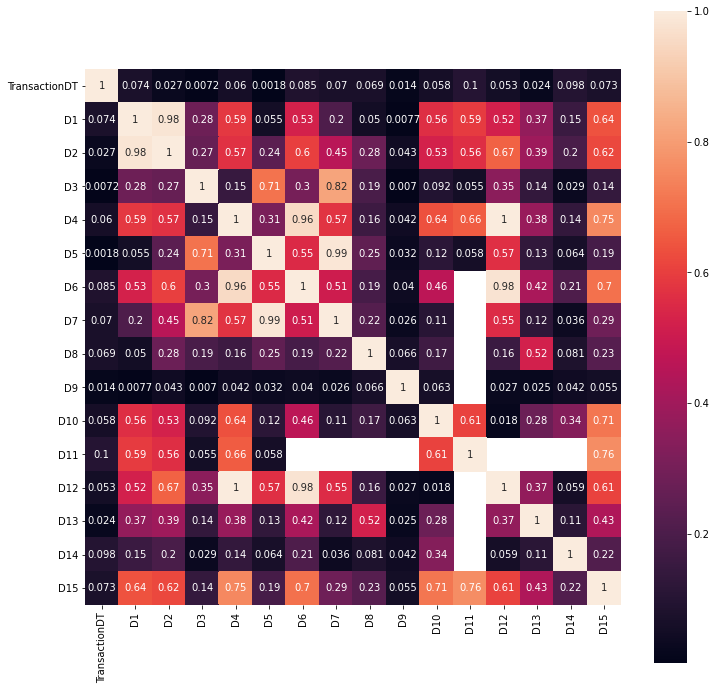

In [77]:
fig, ax = plt.subplots(figsize=(12,12) )    # Sample figsize in inches
ax = sns.heatmap(abs(tx[deltas].corr()), square=True, annot=True )


Some helpful discussion the the Kaggle post noted that transaction dt seems to be in seconds


>Carlos Miranda • (1656th in this Competition) • 2 years ago • Options • Report • Reply
>
>
>Hi! TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.
>
>It looks like D9 is in hours and has been scaled down to 0-1 interval (if you multiply D9 by 24, you get the range 0 to 23).


That means there may be some interesting information to be inferred about day of week or time of day. 


In [127]:
tx["TransDay"] = ((tx.TransactionDT/86400) % 7).astype("int64")


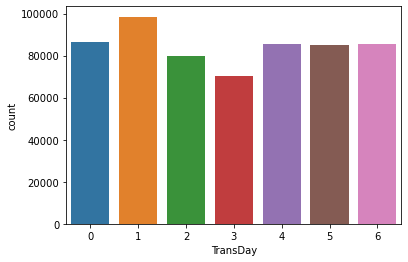

In [132]:
sns.countplot(tx["TransDay"] )

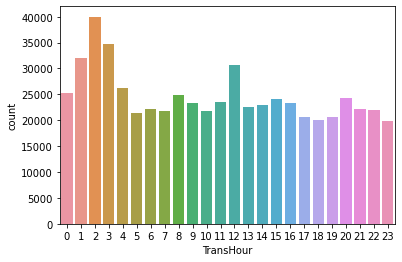

In [151]:
tx["TransHour"] =((tx['TransactionDT']/183/3600)).astype("int64")
sns.countplot(tx.TransHour)

In [152]:
deltas = deltas.to_list() + ["TransDay", "TransHour"]

AttributeError: 'list' object has no attribute 'to_list'

In [153]:
tx[deltas].corr().mask(lambda x:x<.90)

,TransactionDT,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,TransDay,TransHour
TransactionDT,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999152
D1,NaN,1.000000,0.981311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D2,NaN,0.981311,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D4,NaN,NaN,NaN,NaN,1.000000,NaN,0.956966,NaN,NaN,NaN,NaN,NaN,0.999999,NaN,NaN,NaN,NaN,NaN
D5,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.986496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D6,NaN,NaN,NaN,NaN,0.956966,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.976834,NaN,NaN,NaN,NaN,NaN
D7,NaN,NaN,NaN,NaN,NaN,0.986496,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
tx.Trans

0          0
1          0
2          0
3          0
4          0
          ..
590535    23
590536    23
590537    23
590538    23
590539    23
Name: TransHour, Length: 590540, dtype: int64

In [ ]:
null_struct_means = {}
for c in tx:
    name = f"{c}_nan"
    data = pd.get_dummies(tx[c].isna(), drop_first=True)
    if sum(data)==len(data) or sum(data)==0:
        continue
    null_struct_means[name]=data.mean()
    tx[name] = data

In [ ]:
null_struct = tx.filter(regex="nan$")


In [ ]:
check_list = [col for col in null_struct]
dupes = []

for col1 in null_struct:
    check_list.remove(col1)
    for col2 in check_list:
        if sum(null_struct[col1] == null_struct[col2]) == len(null_struct):
            print(col1)
            dupes.append(col1)
        
dupes
        

['ProductCD_nan', 'card4_nan', 'P_emaildomain_nan', 'R_emaildomain_nan', 'M1_nan', 'M2_nan', 'M3_nan', 'M4_nan', 'M5_nan', 'M6_nan', 'M7_nan', 'M8_nan', 'M9_nan', 'card2_nan', 'card3_nan', 'card5_nan', 'card6_nan', 'addr1_nan', 'addr2_nan', 'dist1_nan', 'dist2_nan', 'D1_nan', 'D2_nan', 'D3_nan', 'D4_nan', 'D5_nan', 'D6_nan', 'D7_nan', 'D8_nan', 'D9_nan', 'D10_nan', 'D11_nan', 'D12_nan', 'D13_nan', 'D14_nan', 'D15_nan', 'V1_nan', 'V2_nan', 'V3_nan', 'V4_nan', 'V5_nan', 'V6_nan', 'V7_nan', 'V8_nan', 'V9_nan', 'V10_nan', 'V11_nan', 'V12_nan', 'V13_nan', 'V14_nan', 'V15_nan', 'V16_nan', 'V17_nan', 'V18_nan', 'V19_nan', 'V20_nan', 'V21_nan', 'V22_nan', 'V23_nan', 'V24_nan', 'V25_nan', 'V26_nan', 'V27_nan', 'V28_nan', 'V29_nan', 'V30_nan', 'V31_nan', 'V32_nan', 'V33_nan', 'V34_nan', 'V35_nan', 'V36_nan', 'V37_nan', 'V38_nan', 'V39_nan', 'V40_nan', 'V41_nan', 'V42_nan', 'V43_nan', 'V44_nan', 'V45_nan', 'V46_nan', 'V47_nan', 'V48_nan', 'V49_nan', 'V50_nan', 'V51_nan', 'V52_nan', 'V53_nan', 'V5

,ProductCD_nan,card4_nan,P_emaildomain_nan,R_emaildomain_nan,M1_nan,M2_nan,M3_nan,M4_nan,M5_nan,M6_nan,...,V330_nan,V331_nan,V332_nan,V333_nan,V334_nan,V335_nan,V336_nan,V337_nan,V338_nan,V339_nan
ProductCD_nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card4_nan,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P_emaildomain_nan,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R_emaildomain_nan,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M1_nan,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V335_nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
V336_nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
V337_nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
V338_nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
